# Getting data

In [1]:
from google.colab import files
uploaded = files.upload()


Saving Traffic_Crashes_Resulting_in_Injury_20240416.csv to Traffic_Crashes_Resulting_in_Injury_20240416.csv


In [3]:
import pandas as pd
import io

df = pd.read_csv(io.BytesIO(uploaded['Traffic_Crashes_Resulting_in_Injury_20240416.csv']))


<ipython-input-3-f68d4a25811d>:4: DtypeWarning: Columns (3,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.BytesIO(uploaded['Traffic_Crashes_Resulting_in_Injury_20240416.csv']))


# Subsetting data
Dataset includes data over a long period of time. I will check to see if data has been consistently collected over the whole time period and select a period of time to use for this analysis.

If possible, it would be ideal to use only pre-COVID data to help model find predictable trends without the decline in travel from the lockdown affecting the model's accuracy.

In [14]:
df['accident_year'] = df['accident_year'].astype(int)

accident_year  month    
2005           April        268
               August       258
               December     252
               February     224
               January      245
               July         258
               June         297
               March        281
               May          299
               November     295
               October      289
               September    291
2006           April        231
               August       263
               December     237
               February     281
               January      257
               July         235
               June         272
               March        241
               May          247
               November     171
               October      211
               September    250
2007           April        264
               August       307
               December     249
               February     215
               January      235
               July         235
               

<Axes: xlabel='accident_year,month'>

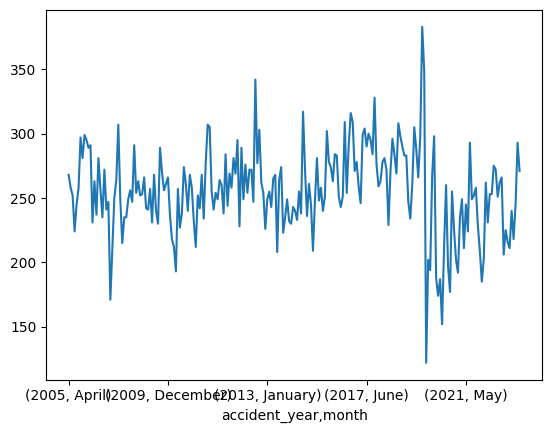

In [35]:
# there is an expected drop in accidents around early 2020
# most likely due to the pandemic
yearly_counts = df.groupby(by=['accident_year', 'month']).size()
print(yearly_counts)
yearly_counts.plot(kind='line')

In [116]:
selected_years = df[(df['accident_year'] < 2020) & (df['accident_year'] > 2013)].sort_values(by='collision_datetime')

# Selecting columns

In [50]:
selected_years.head()

,unique_id,cnn_intrsctn_fkey,cnn_sgmt_fkey,case_id_pkey,tb_latitude,tb_longitude,geocode_source,geocode_location,collision_datetime,collision_date,collision_time,accident_year,month,day_of_week,time_cat,juris,officer_id,reporting_district,beat_number,primary_rd,secondary_rd,distance,direction,weather_1,weather_2,collision_severity,type_of_collision,mviw,ped_action,road_surface,road_cond_1,road_cond_2,lighting,control_device,intersection,vz_pcf_code,vz_pcf_group,vz_pcf_description,vz_pcf_link,number_killed,number_injured,street_view,dph_col_grp,dph_col_grp_description,party_at_fault,party1_type,party1_dir_of_travel,party1_move_pre_acc,party2_type,party2_dir_of_travel,party2_move_pre_acc,point,data_as_of,data_updated_at,data_loaded_at,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods
23592,28697,25121000.0,NaN,150000146,37.795198,-122.413188,SFPD-CROSSROADS,CITY STREET,01/01/2015 01:11:00 AM,2015 January 01,01:11:00,2015,January,Thursday,10:01 pm to 2:00 am,3801,2239,CENTRAL,311E,JACKSON ST,TAYLOR ST,0.0,Not Stated,Clear,Not Stated,Injury (Complaint of Pain),Broadside,Other Motor Vehicle,No Pedestrian Involved,Dry,No Unusual Condition,Not Stated,Dark - Street Lights,Functioning,Intersection <= 20ft,21803(a),"21803(a,b)",Violation of Yield sign,http://leginfo.legislature.ca.gov/faces/codes_...,0.0,1,https://maps.google.com/maps?q=&layer=c&cbll=3...,AA,Vehicle(s) Only Involved,NaN,Driver,South,Proceeding Straight,Driver,West,Proceeding Straight,POINT (-122.413187771 37.795197817),01/01/2015 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,16.0,16.0,6.0,3.0,21.0
40932,26406,24919000.0,10630000.0,150000221,37.788013,-122.410596,SFPD-CROSSROADS,CITY STREET,01/01/2015 01:40:00 AM,2015 January 01,01:40:00,2015,January,Thursday,10:01 pm to 2:00 am,3801,2313,CO J,3J3E,MASON ST,ELLIS ST,155.0,South,Clear,Not Stated,Injury (Complaint of Pain),Rear End,Other Motor Vehicle,No Pedestrian Involved,Dry,No Unusual Condition,Not Stated,Dark - Street Lights,Functioning,Midblock > 20ft,21703,21703,Following too closely prohibited,http://leginfo.legislature.ca.gov/faces/codes_...,0.0,2,https://maps.google.com/maps?q=&layer=c&cbll=3...,AA,Vehicle(s) Only Involved,NaN,Driver,South,Proceeding Straight,Driver,South,Stopped In Road,POINT (-122.410596041 37.788013245),01/01/2015 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,50.0,50.0,6.0,3.0,21.0
33287,35543,26972000.0,11716000.0,150000334,37.800357,-122.441211,SFPD-CROSSROADS,CITY STREET,01/01/2015 01:50:00 AM,2015 January 01,01:50:00,2015,January,Thursday,10:01 pm to 2:00 am,3801,188,E,4T2E,CHESTNUT ST,STEINER ST,66.0,West,Clear,Not Stated,Injury (Complaint of Pain),Vehicle/Pedestrian,Pedestrian,Crossing Not in Crosswalk,Dry,No Unusual Condition,Not Stated,Dark - Street Lights,NaN,Midblock > 20ft,22106,22106,Unsafe starting or backing on highway,http://leginfo.legislature.ca.gov/faces/codes_...,0.0,1,https://maps.google.com/maps?q=&layer=c&cbll=3...,BB,Vehicle-Pedestrian,1.0,Driver,East,Backing,Pedestrian,South,Other,POINT (-122.441211364 37.800356751),01/01/2015 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,17.0,17.0,4.0,6.0,13.0
16749,38398,23325000.0,11942000.0,150001724,37.726554,-122.502537,SFPD-CROSSROADS,CITY STREET,01/01/2015 02:05:00 PM,2015 January 01,14:05:00,2015,January,Thursday,2:01 pm to 6:00 pm,3801,1053,TARAVAL,3115A,SKYLINE BLVD,HARDING RD,12.0,North,Clear,Not Stated,Injury (Complaint of Pain),Broadside,Bicycle,No Pedestrian Involved,Dry,No Unusual Condition,Not Stated,Daylight,Functioning,Intersection <= 20ft,21802(a),"21802(a,b)",Violation of right-of-way - entering through h...,http://leginfo.legislature.ca.gov/faces/codes_...,0.0,1,https://maps.google.com/maps?q=&layer=c&cbll=3...,CC,Vehicle-Bicycle,1.0,Bicyclist,West,Entering Traffic,Driver,North,Proceeding Straight,POINT (-122.502537252 37.726554349),01/01/2015 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,43.0,43.0,10.0,8.

In [117]:
selected_years.columns

Index(['unique_id', 'cnn_intrsctn_fkey', 'cnn_sgmt_fkey', 'case_id_pkey',
       'tb_latitude', 'tb_longitude', 'geocode_source', 'geocode_location',
       'collision_datetime', 'collision_date', 'collision_time',
       'accident_year', 'month', 'day_of_week', 'time_cat', 'juris',
       'officer_id', 'reporting_district', 'beat_number', 'primary_rd',
       'secondary_rd', 'distance', 'direction', 'weather_1', 'weather_2',
       'collision_severity', 'type_of_collision', 'mviw', 'ped_action',
       'road_surface', 'road_cond_1', 'road_cond_2', 'lighting',
       'control_device', 'intersection', 'vz_pcf_code', 'vz_pcf_group',
       'vz_pcf_description', 'vz_pcf_link', 'number_killed', 'number_injured',
       'street_view', 'dph_col_grp', 'dph_col_grp_description',
       'party_at_fault', 'party1_type', 'party1_dir_of_travel',
       'party1_move_pre_acc', 'party2_type', 'party2_dir_of_travel',
       'party2_move_pre_acc', 'point', 'data_as_of', 'data_updated_at',
       'data_

In [118]:
selected_years.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19575 entries, 1556 to 5475
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   unique_id                     19575 non-null  int64  
 1   cnn_intrsctn_fkey             19575 non-null  float64
 2   cnn_sgmt_fkey                 8003 non-null   float64
 3   case_id_pkey                  19575 non-null  object 
 4   tb_latitude                   19469 non-null  float64
 5   tb_longitude                  19469 non-null  float64
 6   geocode_source                19575 non-null  object 
 7   geocode_location              19575 non-null  object 
 8   collision_datetime            19575 non-null  object 
 9   collision_date                19575 non-null  object 
 10  collision_time                19540 non-null  object 
 11  accident_year                 19575 non-null  int64  
 12  month                         19575 non-null  object 
 13  day_

In [120]:
test_df = selected_years[['unique_id', 'tb_latitude', 'tb_longitude', 'collision_datetime', 'collision_date']]
test_df.loc[:, 'collision_datetime'] = pd.to_datetime(test_df['collision_datetime'])
test_df.loc[:, 'collision_date'] = pd.to_datetime(test_df['collision_date']).dt.date

In [121]:
grouped = test_df.groupby(by=["collision_date"]).size()
grouped.index = pd.to_datetime(grouped.index)

# check if there's any missing dates
start_date = '2015-01-01'
end_date = '2018-12-31'
date_range = pd.date_range(start=start_date, end=end_date)

grouped = grouped.to_frame()
grouped = grouped.reset_index()
grouped = grouped.rename(columns={0:"accident_count"})

In [122]:
grouped.head()

,collision_date,accident_count
0,2014-01-01,7
1,2014-01-02,4
2,2014-01-03,5
3,2014-01-04,9
4,2014-01-05,6


In [144]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np

In [126]:
# set random seed for reproducibility
tf.random.set_seed(7)

In [129]:
dataset = grouped["accident_count"].values.astype('float32')
dataset

array([ 7.,  4.,  5., ...,  6.,  7., 11.], dtype=float32)

In [139]:
dataset = dataset.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [141]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [142]:
print(len(train), len(test))

1467 724


In [147]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [163]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [168]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

ValueError: cannot reshape array of size 4389 into shape (1463,1,1)

In [165]:
print(len(trainX), len(trainY))

1465 1465


In [166]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100


KeyboardInterrupt: 

In [156]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

23/23 [==============================] - 0s 3ms/step
Train Score: 3.24 RMSE
Test Score: 3.67 RMSE


In [169]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [170]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1463/1463 - 5s - loss: 0.0291 - 5s/epoch - 3ms/step
Epoch 2/100
1463/1463 - 4s - loss: 0.0221 - 4s/epoch - 3ms/step
Epoch 3/100
1463/1463 - 3s - loss: 0.0219 - 3s/epoch - 2ms/step
Epoch 4/100
1463/1463 - 3s - loss: 0.0219 - 3s/epoch - 2ms/step
Epoch 5/100
1463/1463 - 3s - loss: 0.0218 - 3s/epoch - 2ms/step
Epoch 6/100
1463/1463 - 4s - loss: 0.0218 - 4s/epoch - 3ms/step
Epoch 7/100
1463/1463 - 3s - loss: 0.0219 - 3s/epoch - 2ms/step
Epoch 8/100
1463/1463 - 3s - loss: 0.0218 - 3s/epoch - 2ms/step
Epoch 9/100
1463/1463 - 6s - loss: 0.0218 - 6s/epoch - 4ms/step
Epoch 10/100
1463/1463 - 3s - loss: 0.0218 - 3s/epoch - 2ms/step
Epoch 11/100
1463/1463 - 3s - loss: 0.0218 - 3s/epoch - 2ms/step
Epoch 12/100
1463/1463 - 3s - loss: 0.0217 - 3s/epoch - 2ms/step
Epoch 13/100
1463/1463 - 4s - loss: 0.0218 - 4s/epoch - 3ms/step
Epoch 14/100
1463/1463 - 3s - loss: 0.0218 - 3s/epoch - 2ms/step
Epoch 15/100
1463/1463 - 3s - loss: 0.0220 - 3s/epoch - 2ms/step
Epoch 16/100
1463/1463 - 3s - loss

In [171]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

23/23 [==============================] - 0s 3ms/step
Train Score: 3.25 RMSE
Test Score: 3.66 RMSE
